Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]
Epoch 1/10: 100%|██████████| 191/191 [01:00<00:00,  3.14batch/s, loss=0.0879] 


Epoch 1: Loss=0.1065, Accuracy=0.9680


Epoch 2/10: 100%|██████████| 191/191 [00:44<00:00,  4.33batch/s, loss=0.0835] 


Epoch 2: Loss=0.0228, Accuracy=0.9931


Epoch 3/10: 100%|██████████| 191/191 [00:43<00:00,  4.36batch/s, loss=0.0188]  


Epoch 3: Loss=0.0131, Accuracy=0.9956


Epoch 4/10: 100%|██████████| 191/191 [00:45<00:00,  4.24batch/s, loss=0.00909] 


Epoch 4: Loss=0.0078, Accuracy=0.9980


Epoch 5/10: 100%|██████████| 191/191 [00:42<00:00,  4.46batch/s, loss=0.000471]


Epoch 5: Loss=0.0016, Accuracy=1.0000


Epoch 6/10: 100%|██████████| 191/191 [00:44<00:00,  4.25batch/s, loss=0.0562]  


Epoch 6: Loss=0.0045, Accuracy=0.9989


Epoch 7/10: 100%|██████████| 191/191 [00:45<00:00,  4.21batch/s, loss=0.000491]


Epoch 7: Loss=0.0054, Accuracy=0.9980


Epoch 8/10: 100%|██████████| 191/191 [00:45<00:00,  4.21batch/s, loss=0.0003]  


Epoch 8: Loss=0.0036, Accuracy=0.9997


Epoch 9/10: 100%|██████████| 191/191 [00:43<00:00,  4.35batch/s, loss=0.0155]  


Epoch 9: Loss=0.0037, Accuracy=0.9985


Epoch 10/10: 100%|██████████| 191/191 [00:43<00:00,  4.39batch/s, loss=0.00238] 


Epoch 10: Loss=0.0062, Accuracy=0.9982


Evaluating: 100%|██████████| 22/22 [00:05<00:00,  3.98it/s]


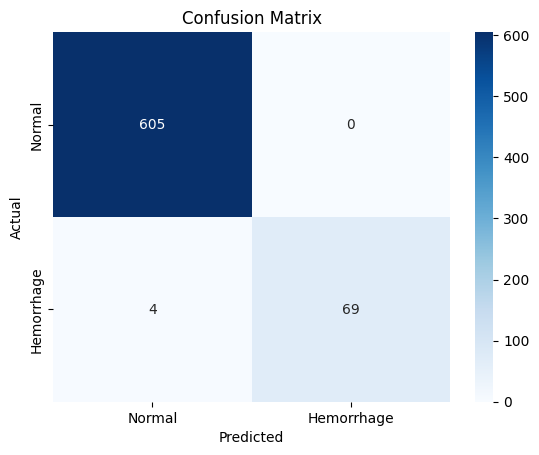

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       605
  Hemorrhage       1.00      0.95      0.97        73

    accuracy                           0.99       678
   macro avg       1.00      0.97      0.98       678
weighted avg       0.99      0.99      0.99       678



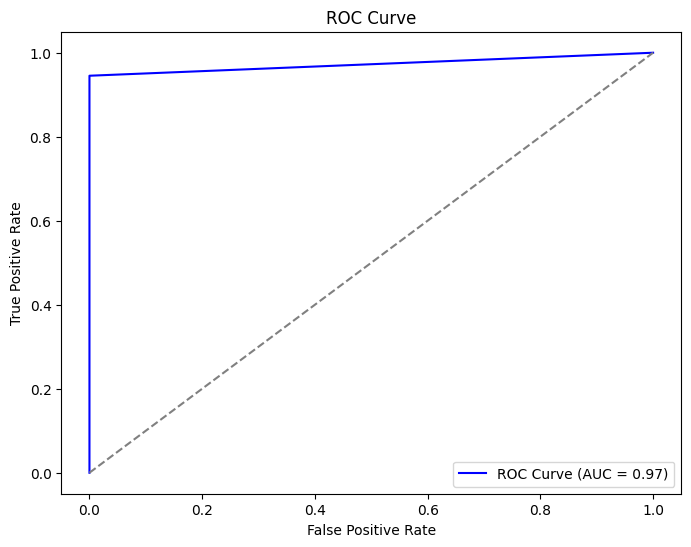

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.datasets import ImageFolder

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data
Brain_CT_Path = Path("../input/brain-ct-hemorrhage-dataset/Data")
JPG_Path = list(Brain_CT_Path.glob(r"**/*.jpg"))
JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], JPG_Path))

JPG_Path_Series = pd.Series(JPG_Path, name="JPG").astype(str)
JPG_Labels_Series = pd.Series(JPG_Labels, name="CATEGORY")

Main_Data = pd.concat([JPG_Path_Series, JPG_Labels_Series], axis=1)

# Simplify categories
Main_Data["CATEGORY"].replace({
    "11[11]": "Hemorrhage", "12[12]": "Hemorrhage", "13[13]": "Hemorrhage",
    "14[14]": "Hemorrhage", "N10[N10]": "Normal", "N11[N11]": "Normal"}, inplace=True)

# Shuffle data
Main_Data = Main_Data.sample(frac=1).reset_index(drop=True)

# Split into training and test sets
Train_Data, Test_Data = train_test_split(Main_Data, train_size=0.9, shuffle=True, random_state=42)

# Custom Dataset
class BrainCTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = 1 if self.dataframe.iloc[idx, 1] == "Hemorrhage" else 0
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets and Dataloaders
train_dataset = BrainCTDataset(Train_Data, transform=train_transform)
test_dataset = BrainCTDataset(Test_Data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load ResNet18 Model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Function
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    model.train()
    history = {'train_loss': [], 'train_accuracy': []}
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        with tqdm(train_loader, unit="batch") as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")
                images, labels = images.to(device), labels.to(device).float()

                optimizer.zero_grad()
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                predicted = torch.sigmoid(outputs) > 0.5
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                tepoch.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)
        print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={epoch_accuracy:.4f}")
    return history

# Train the Model
history = train_model(model, criterion, optimizer, train_loader, num_epochs=10)

# Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            predictions = torch.sigmoid(outputs) > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predictions.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

true_labels, predictions = evaluate_model(model, test_loader)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Hemorrhage'],
            yticklabels=['Normal', 'Hemorrhage'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=['Normal', 'Hemorrhage']))

# ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Save the Model
torch.save(model.state_dict(), "resnet18_brain_ct_model.pth")
